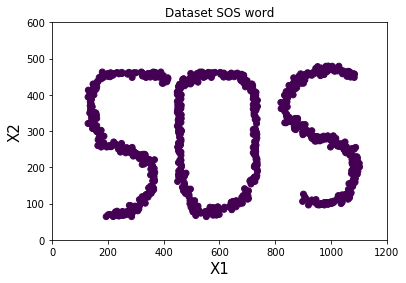

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Dataset
def paint_dataset():
    sample_dataset=plt.imread("C:\\Users\\TALYXD\\Desktop\\mizzou_spring_2021_nn_deploy-master\\mizzou_spring_2021_nn_deploy-master\\Neural Network Class\\Project2\\Sample Dataset.jpg")
    sample_dataset=sample_dataset.astype(float)
    index2=(sample_dataset[:,:,0]*255)-(sample_dataset[:,:,1]*255)
    ##Purple
    n1=np.where(index2>(5))
    y1=np.zeros((n1[0].shape[0],1))
    ##Yellow
    n0=np.where((sample_dataset[:,:,0]*255<100)*1)
    y2=np.ones((n0[0].shape[0],1))

    Y=np.concatenate((y1,y2)).reshape(n1[0].shape[0]+n0[0].shape[0],1)
    n1=np.stack((n1[1],n1[0]))
    n0=np.stack((n0[1],n0[0]))
    X=np.hstack((n1,n0))
    X[0,:]=np.abs(1200-X[0,:])
    #Shuffling dataset 
    X_Train, X_Test, Y_Train, Y_Test  = train_test_split(X.transpose(), Y, test_size=0.33, random_state=42)
    #Return 1000 dataset for training and 500 for testing
    return(X_Train[0:1000,:], Y_Train[0:1000,:], X_Test[0:1000,:], Y_Test[0:1000,:])

X_Train, Y_Train, X_Test, Y_Test=paint_dataset()
Y_Train=Y_Train.reshape(Y_Train.shape[0])
plt.figure(5)
plt.title('Dataset SOS word')
plt.scatter(X_Train[:,0],X_Train[:,1],c=(Y_Train>0.5))
plt.xlabel('X1', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('X2', fontsize = 15) # y-axis label with fontsize 15
plt.xlim(0,1200)
plt.ylim(0,600)
plt.show()

#Parameter

class GNG:
    #Initialization 
    def __init__(self,ndim,Alpha,d,a_max,l,epsb,epsn,iteration,epoch,total_nodes):
        self.weight=np.float64(np.random.normal(0,1,(2,ndim)))#Initial Weights variables
        self.Adj= np.float64(np.zeros((2,2))) ##Initial Adjacent matrix variables 
        self.T= np.float64(np.zeros((2,2))) #Initial Age variables
        self.Error= np.float64(np.array([0,0])) #Initial Error variables
        self.d=d # constant to reduce the entire error variables  
        self.Alpha=Alpha # constant to reduce error of neuron used to create new neuron 
        self.a_max=a_max #maximum age of neuron nodes 
        self.l=l #multiplier to increase the neuron 
        self.RandomState=np.random.seed(61000)# random seed
        self.epsb=epsb #the constant multiplier to move the nearest neuron closer to signal
        self.epsn=epsn #the constant multiplier to move the neighbor of nearest neuron closer to signal
        self.iteration=iteration #number of iteration run for the algorithm
        self.epoch=epoch #number of epoch run for the algorithm
        self.total_nodes=total_nodes #number of maximum of neuron node used 
    def iterate(self,X):
        
        #Step 0
        #Embededed in Initialization
        #Step 1
        for j in range(self.epoch):
            np.random.shuffle(X)
            for i in range(self.iteration):
#                 print('epoch: '+str(j)+' and iteration: '+str(i))
                signal=X[i,:]
                #Step 2
                nearest_1,nearest_2=self.nearest_unit(signal)
                #Step 3
                self.increment(nearest_1)
                #Step 4
                self.adding_error(signal,nearest_1)
                #Step 5
                self.move_s1_and_neighor(signal,nearest_1)
                #Step 6
                self.set_edge_for_nearest_unit(nearest_1,nearest_2)
                #Step 7
                self.remove_edges_above_a_max()
                #Step 8
                self.create_neuron_for_highest_error(i,X,signal)
                #Step 9
                self.decrease_all_error()
                #Step 10
                if (self.iteration==i and self.epoch==j):
                    break
    #Step 2
    def nearest_unit(self,signal):
        #Calculate distance between signal and all neuron
        distance=np.linalg.norm(signal-self.weight,axis=1)**2
        #Sorting to find the two nearest neuron to signal 
        index=np.argsort(distance)
        #Extract neuron nearest 1
        nearest_1=index[0]
        #Extract neuron nearest 2
        nearest_2=index[1] 
        #return two nearest neuron 
        return(nearest_1,nearest_2)
    #Step 3
    def increment(self,nearest_unit1):
        #Looping to check neighbor of nearest neuron 1
        for i in range(self.Adj[nearest_unit1].shape[0]):
            #Checking Connection 
            if self.Adj[nearest_unit1,i]==1 and self.Adj[i,nearest_unit1]==1:
                #Add Age for symetric connection
                self.T[nearest_unit1,i]=self.T[nearest_unit1,i]+1
                self.T[i,nearest_unit1]=self.T[i,nearest_unit1]+1
    #Step 4
    def adding_error(self,signal,nearest_unit1):
        #Add Squared distance error of nearest unit 1
        self.Error[nearest_unit1] += (np.linalg.norm(self.weight[nearest_unit1,:]-signal)**2)
    #Step 5
    def move_s1_and_neighor(self,signal,nearest_unit1):
        #Move the s1
        self.weight[nearest_unit1,:]=self.weight[nearest_unit1,:]+(self.epsb*(signal-self.weight[nearest_unit1,:]))       
        #Move the neighbor
        for i in range(self.Adj[nearest_unit1].shape[0]):
            if self.Adj[nearest_unit1,i]==1 and self.Adj[i,nearest_unit1]==1:
                self.weight[i,:]=self.weight[i,:]+(self.epsn*(signal-self.weight[i,:]))
    #Step 6            
    def set_edge_for_nearest_unit(self,nearest_unit1,nearest_unit2):
        #If they are connected, turn  their age of the edge to zero
        if self.Adj[nearest_unit1,nearest_unit2]==1 and self.Adj[nearest_unit2,nearest_unit1]==1:
            self.T[nearest_unit1,nearest_unit2]=0
            self.T[nearest_unit2,nearest_unit1]=0
        #if they are not connected make it connected 
        else:
            self.Adj[nearest_unit1,nearest_unit2]=1
            self.T[nearest_unit1,nearest_unit2]=0
            #Symetric
            self.Adj[nearest_unit2,nearest_unit1]=1
            self.T[nearest_unit2,nearest_unit1]=0
    #Step 7  
    def remove_edges_above_a_max(self):
        #Remove connection of edges with >a_max
        self.Adj[self.T>self.a_max]=0
        self.T[self.T>self.a_max]=0
        #calculate the number of neighbor based on both axis 1 and 0
        Adjsum1=np.sum(self.Adj,axis=0)
        Adjsum2=np.sum(self.Adj,axis=1)
        # Checking and list the neuron that has no neighbor connection
        delete_list=[]
        for i in range(len(Adjsum1)):
            if Adjsum1[i]==0 and Adjsum2[i]==0:
                delete_list.append(i)
        # Deleting neuron that has no neighbor connection
        if len(delete_list)>0:
            self.Adj=np.delete(self.Adj,delete_list,1)
            self.T=np.delete(self.T,delete_list,1)
            self.Adj=np.delete(self.Adj,delete_list,0)
            self.T=np.delete(self.T,delete_list,0)
            self.weight=np.delete(self.weight,delete_list,0)
            self.Error=np.delete(self.Error,delete_list,0)
    #Step 8            
    def create_neuron_for_highest_error(self,iteration,X,signal):
        #Add neuron if number of neuron < total_node 
        # and if iteration is multiple of lambda=l 
        if self.total_nodes>len(self.Error) and iteration%self.l==0:
            # Find q which is the highest error neuron
            q=np.argmax(self.Error)
            # Find f the the neighbor of q 
            # and highest error neuron 
            max_error=self.Error[0]
            f=0
            for i in range(self.Adj.shape[0]):
                if self.Adj[q,i]==1 and self.Adj[i,q]==1:
                    error=self.Error[i]
                    if error>max_error:
                        max_error=error
                        f=i
            # Reduce the error of q and f by multipying with alpha
            self.Error[q]=self.Error[q]*self.Alpha
            self.Error[f]=self.Error[f]*self.Alpha
            #Break the connection between f and q 
            if self.Adj[q,f]==1 and self.Adj[f,q]==1:
                self.Adj[q,f]=0
                #Symetric
                self.Adj[f,q]=0
            #creating r unit neuron 
            r=0.5*(self.weight[q]+self.weight[f]) 
            #Adding new weight
            self.weight=np.vstack((self.weight,r)) 
            #Adding new Error 
            self.Error=np.hstack((self.Error,self.Error[q]))
            #Adding new Age=T
            new_column=np.zeros((self.T.shape[0],1))
            new_row=np.zeros((1,self.T.shape[1]+1))
            self.T=np.hstack((self.T,new_column))
            self.T=np.vstack((self.T,new_row))
            #Adding new edge to Adj
            new_column=np.zeros((self.Adj.shape[0],1))
            new_row=np.zeros((1,self.Adj.shape[1]+1))
            self.Adj=np.hstack((self.Adj,new_column))
            self.Adj=np.vstack((self.Adj,new_row))
            #Add connection between r and f and r and q
            self.Adj[q,-1]=1
            self.Adj[f,-1]=1
            #Symetric
            self.Adj[-1,q]=1
            self.Adj[-1,f]=1
    #Step 9
    def decrease_all_error(self):
        #Multiply all error with constant d 
        self.Error=self.Error*self.d
        
    


This running is for variable epoch: 3 and variable iteration: 100
This running is for variable epoch: 3 and variable iteration: 500
This running is for variable epoch: 3 and variable iteration: 1000
This running is for variable epoch: 5 and variable iteration: 100
This running is for variable epoch: 5 and variable iteration: 500
This running is for variable epoch: 5 and variable iteration: 1000
This running is for variable epoch: 10 and variable iteration: 100
This running is for variable epoch: 10 and variable iteration: 500
This running is for variable epoch: 10 and variable iteration: 1000


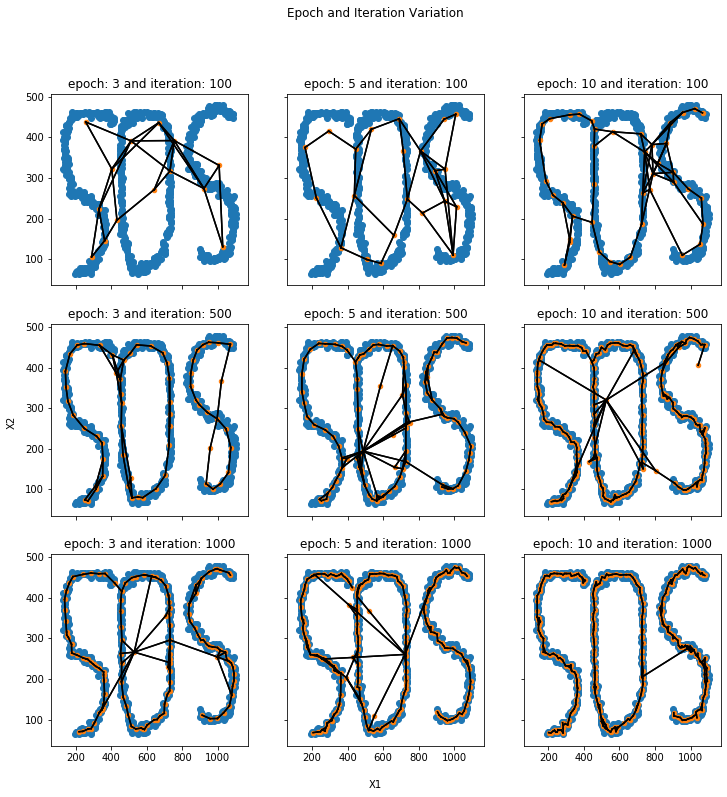

In [6]:
#####Parameters
All_Alpha=[0.1,0.25,0.5]
All_d=[0.3,0.5,0.995]
All_a_max=[10,25,50]
All_l=[10,25,50]
All_epsb=[0.2,0.5,1]
All_epsn=[0.005,0.1,0.5]
ndim=2
All_iteration=[100,500,1000]
All_epoch=[3,5,10]
All_total_nodes=[100,250,500]
counter_row=0
counter_col=0
################################################3
# Epoch and Iteration Variation
################################################

for i in All_epoch:
    counter_row=0
    for j in All_iteration:
        print('This running is for variable epoch: '+str(i)+' and variable iteration: '+str(j))
        Model=GNG(ndim,All_Alpha[1],All_d[1],All_a_max[1],All_l[1],All_epsb[1],All_epsn[1],j,i,All_total_nodes[1])
        Model.iterate(X_Train)
        if counter_row==0 and counter_col==0:
            fig, axs = plt.subplots(3, 3,figsize=(12,12),sharex=True,sharey=True)
            fig.suptitle('Epoch and Iteration Variation')

        axs[counter_row,counter_col].scatter(X_Train[:,0],X_Train[:,1])
        axs[counter_row,counter_col].scatter(Model.weight[:,0],Model.weight[:,1],s=20)
        for k in range(Model.Adj.shape[0]):
            for l in range(Model.Adj.shape[1]):
                Weight=Model.weight[k,:]
                if Model.Adj[k,l]==1:
                    Weight=np.vstack((Weight,Model.weight[l,:]))
                    line,=axs[counter_row,counter_col].plot(Weight[:,0],Weight[:,1],color='black')
        axs[counter_row,counter_col].set_title('epoch: '+str(i)+' and iteration: '+str(j))
        counter_row+=1
    counter_col+=1
fig.text(0.5, 0.08, 'X1', ha='center', va='center')
fig.text(0.08, 0.5, 'X2', ha='center', va='center', rotation='vertical')
plt.show()



This running is for Number of Maximum Total Nodes: 100
This running is for Number of Maximum Total Nodes: 250
This running is for Number of Maximum Total Nodes: 500


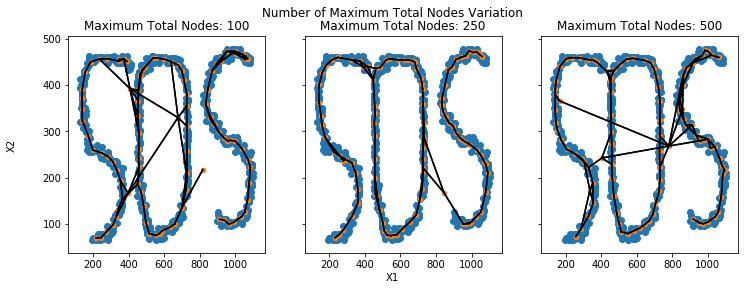

In [7]:
#####Parameters
All_Alpha=[0.1,0.25,0.5]
All_d=[0.3,0.5,0.995]
All_a_max=[10,25,50]
All_l=[10,25,50]
All_epsb=[0.2,0.5,1]
All_epsn=[0.005,0.1,0.5]
ndim=2
All_iteration=[100,500,1000]
All_epoch=[3,5,10]
All_total_nodes=[100,250,500]
counter_row=0
counter_col=0
#############################################
# Maximum Node of neuron single variation
##########################################
counter_row=0
for i in All_total_nodes:
    print('This running is for Number of Maximum Total Nodes: '+str(i) )
    Model=GNG(ndim,All_Alpha[1],All_d[1],All_a_max[1],All_l[1],All_epsb[1],All_epsn[1],All_iteration[1],All_epoch[1],i)
    Model.iterate(X_Train)
    if counter_row==0 and counter_col==0:
        fig, axs = plt.subplots(1, 3,figsize=(12,4),sharex=True,sharey=True)
        fig.suptitle('Number of Maximum Total Nodes Variation')
    axs[counter_row].scatter(X_Train[:,0],X_Train[:,1])
    axs[counter_row].scatter(Model.weight[:,0],Model.weight[:,1],s=20)
    for k in range(Model.Adj.shape[0]):
        for l in range(Model.Adj.shape[1]):
            Weight=Model.weight[k,:]
            if Model.Adj[k,l]==1:
                Weight=np.vstack((Weight,Model.weight[l,:]))
                line,=axs[counter_row].plot(Weight[:,0],Weight[:,1],color='black')
    axs[counter_row].set_title('Maximum Total Nodes: '+str(i))
    counter_row+=1
fig.text(0.5, 0.04, 'X1', ha='center', va='center')
fig.text(0.06, 0.5, 'X2', ha='center', va='center', rotation='vertical')
plt.show()




This running is for epsilon b: 0.2 and epsilon n: 0.005
This running is for epsilon b: 0.2 and epsilon n: 0.1
This running is for epsilon b: 0.2 and epsilon n: 0.5
This running is for epsilon b: 0.5 and epsilon n: 0.005
This running is for epsilon b: 0.5 and epsilon n: 0.1
This running is for epsilon b: 0.5 and epsilon n: 0.5
This running is for epsilon b: 1 and epsilon n: 0.005
This running is for epsilon b: 1 and epsilon n: 0.1
This running is for epsilon b: 1 and epsilon n: 0.5


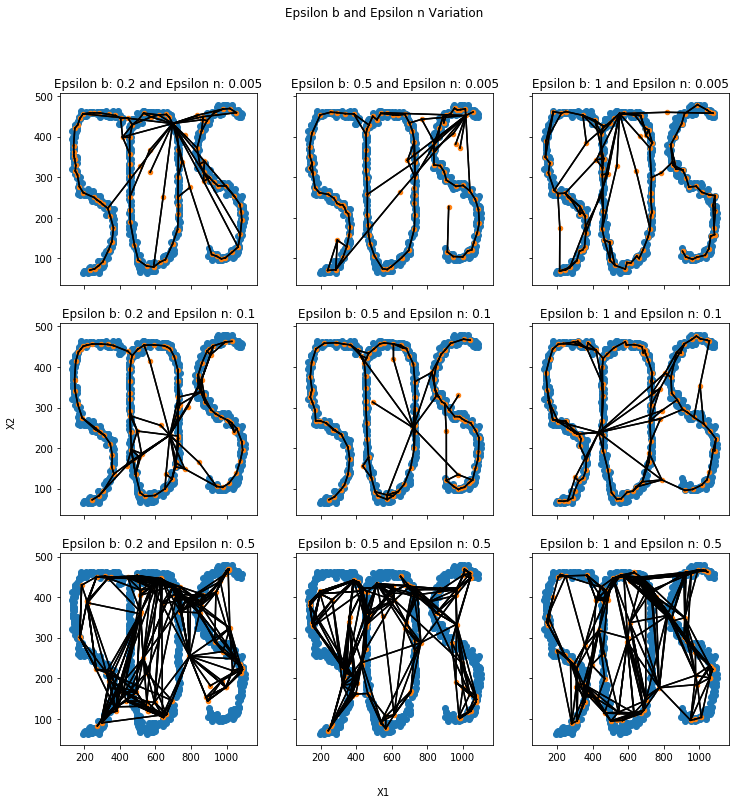

In [8]:
#####Parameters
All_Alpha=[0.1,0.25,0.5]
All_d=[0.3,0.5,0.995]
All_a_max=[10,25,50]
All_l=[10,25,50]
All_epsb=[0.2,0.5,1]
All_epsn=[0.005,0.1,0.5]
ndim=2
All_iteration=[100,500,1000]
All_epoch=[3,5,10]
All_total_nodes=[100,250,500]
counter_row=0
counter_col=0
#############################################
# Epsilon b and Epsilon n  variation
##########################################

for i in All_epsb:
    counter_row=0
    for j in All_epsn:
        print('This running is for epsilon b: '+str(i)+' and epsilon n: '+str(j))
        Model=GNG(ndim,All_Alpha[1],All_d[1],All_a_max[1],All_l[1],i,j,All_iteration[1],All_epoch[1],All_total_nodes[1])
        Model.iterate(X_Train)
        if counter_row==0 and counter_col==0:
            fig, axs = plt.subplots(3, 3,figsize=(12,12),sharex=True,sharey=True)
            fig.suptitle('Epsilon b and Epsilon n Variation')

        axs[counter_row,counter_col].scatter(X_Train[:,0],X_Train[:,1])
        axs[counter_row,counter_col].scatter(Model.weight[:,0],Model.weight[:,1],s=20)
        for k in range(Model.Adj.shape[0]):
            for l in range(Model.Adj.shape[1]):
                Weight=Model.weight[k,:]
                if Model.Adj[k,l]==1:
                    Weight=np.vstack((Weight,Model.weight[l,:]))
                    line,=axs[counter_row,counter_col].plot(Weight[:,0],Weight[:,1],color='black')
        axs[counter_row,counter_col].set_title('Epsilon b: '+str(i)+' and Epsilon n: '+str(j))
        counter_row+=1
    counter_col+=1
fig.text(0.5, 0.07, 'X1', ha='center', va='center')
fig.text(0.07, 0.5, 'X2', ha='center', va='center', rotation='vertical')
plt.show()



This running is for Alpha: 0.1 and d: 0.3
This running is for Alpha: 0.1 and d: 0.5
This running is for Alpha: 0.1 and d: 0.995
This running is for Alpha: 0.25 and d: 0.3
This running is for Alpha: 0.25 and d: 0.5
This running is for Alpha: 0.25 and d: 0.995
This running is for Alpha: 0.5 and d: 0.3
This running is for Alpha: 0.5 and d: 0.5
This running is for Alpha: 0.5 and d: 0.995


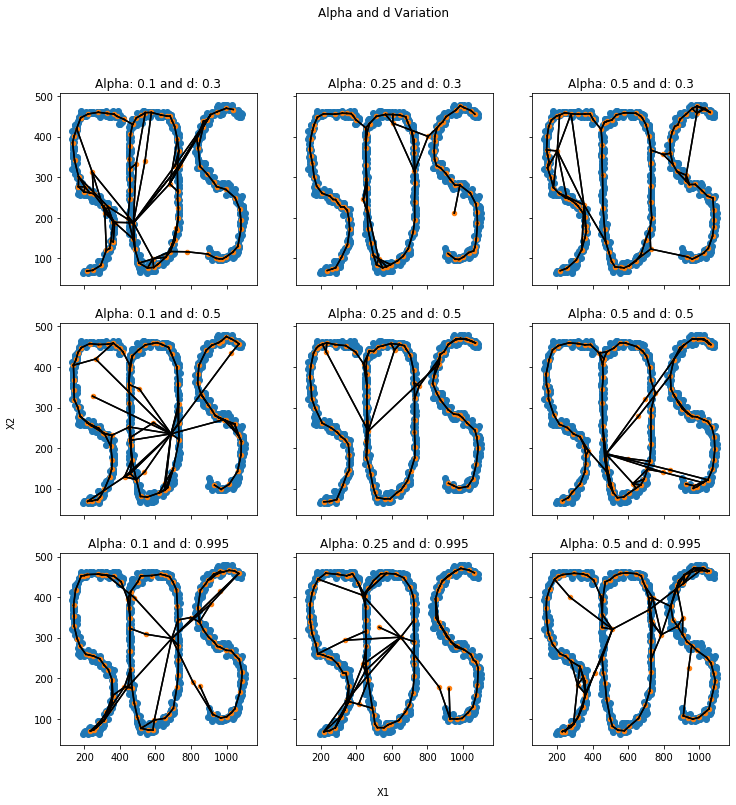

In [9]:
#####Parameters
All_Alpha=[0.1,0.25,0.5]
All_d=[0.3,0.5,0.995]
All_a_max=[10,25,50]
All_l=[10,25,50]
All_epsb=[0.2,0.5,1]
All_epsn=[0.005,0.1,0.5]
ndim=2
All_iteration=[100,500,1000]
All_epoch=[3,5,10]
All_total_nodes=[100,250,500]
counter_row=0
counter_col=0
#############################################
# Alpha and d  variation
##########################################

for i in All_Alpha:
    counter_row=0
    for j in All_d:
        print('This running is for Alpha: '+str(i)+' and d: '+str(j))
        Model=GNG(ndim,i,j,All_a_max[1],All_l[1],All_epsb[1],All_epsn[1],All_iteration[1],All_epoch[1],All_total_nodes[1])
        Model.iterate(X_Train)
        if counter_row==0 and counter_col==0:
            fig, axs = plt.subplots(3, 3,figsize=(12,12),sharex=True,sharey=True)
            fig.suptitle('Alpha and d Variation')

        axs[counter_row,counter_col].scatter(X_Train[:,0],X_Train[:,1])
        axs[counter_row,counter_col].scatter(Model.weight[:,0],Model.weight[:,1],s=20)
        for k in range(Model.Adj.shape[0]):
            for l in range(Model.Adj.shape[1]):
                Weight=Model.weight[k,:]
                if Model.Adj[k,l]==1:
                    Weight=np.vstack((Weight,Model.weight[l,:]))
                    line,=axs[counter_row,counter_col].plot(Weight[:,0],Weight[:,1],color='black')
        axs[counter_row,counter_col].set_title('Alpha: '+str(i)+' and d: '+str(j))
        counter_row+=1
    counter_col+=1
fig.text(0.5, 0.07, 'X1', ha='center', va='center')
fig.text(0.07, 0.5, 'X2', ha='center', va='center', rotation='vertical')
plt.show()



This running is for a_max: 10 and l: 10
This running is for a_max: 10 and l: 25
This running is for a_max: 10 and l: 50
This running is for a_max: 25 and l: 10
This running is for a_max: 25 and l: 25
This running is for a_max: 25 and l: 50
This running is for a_max: 50 and l: 10
This running is for a_max: 50 and l: 25
This running is for a_max: 50 and l: 50


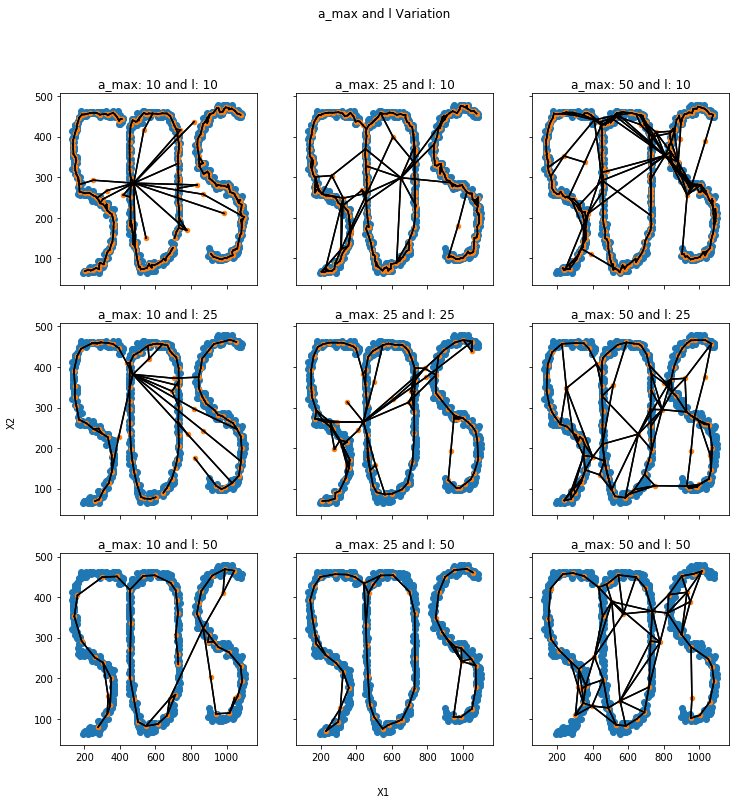

In [10]:
#####Parameters
All_Alpha=[0.1,0.25,0.5]
All_d=[0.3,0.5,0.995]
All_a_max=[10,25,50]
All_l=[10,25,50]
All_epsb=[0.2,0.5,1]
All_epsn=[0.005,0.1,0.5]
ndim=2
All_iteration=[100,500,1000]
All_epoch=[3,5,10]
All_total_nodes=[100,250,500]
counter_row=0
counter_col=0
##############################################
#a_max and l variation
###########################################

for i in All_a_max:
    counter_row=0
    for j in All_l:
        print('This running is for a_max: '+str(i)+' and l: '+str(j))
        Model=GNG(ndim,All_Alpha[1],All_d[1],i,j,All_epsb[1],All_epsn[1],All_iteration[1],All_epoch[1],All_total_nodes[1])
        Model.iterate(X_Train)
        if counter_row==0 and counter_col==0:
            fig, axs = plt.subplots(3, 3,figsize=(12,12),sharex=True,sharey=True)
            fig.suptitle('a_max and l Variation')

        axs[counter_row,counter_col].scatter(X_Train[:,0],X_Train[:,1])
        axs[counter_row,counter_col].scatter(Model.weight[:,0],Model.weight[:,1],s=20)
        for k in range(Model.Adj.shape[0]):
            for l in range(Model.Adj.shape[1]):
                Weight=Model.weight[k,:]
                if Model.Adj[k,l]==1:
                    Weight=np.vstack((Weight,Model.weight[l,:]))
                    line,=axs[counter_row,counter_col].plot(Weight[:,0],Weight[:,1],color='black')
        axs[counter_row,counter_col].set_title('a_max: '+str(i)+' and l: '+str(j))
        counter_row+=1
    counter_col+=1
fig.text(0.5, 0.07, 'X1', ha='center', va='center')
fig.text(0.07, 0.5, 'X2', ha='center', va='center', rotation='vertical')
plt.show()




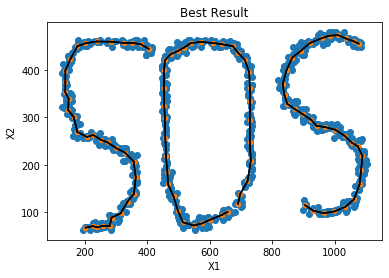

In [12]:
##########################################
# Best Result
##########################################

Best_Alpha=0.25
Best_d=0.995
Best_a_max=10
Best_l=50
Best_epsb=0.2
Best_epsn=0.005
ndim=2
Best_iteration=1000
Best_epoch=10
Best_total_nodes=100

Model=GNG(ndim,Best_Alpha,Best_d,Best_a_max,Best_l,Best_epsb,Best_epsn,Best_iteration,Best_epoch,Best_total_nodes)
Model.iterate(X_Train)

plt.figure(0)
plt.scatter(X_Train[:,0],X_Train[:,1])
plt.scatter(Model.weight[:,0],Model.weight[:,1],s=20)
for k in range(Model.Adj.shape[0]):
    for l in range(Model.Adj.shape[1]):
        Weight=Model.weight[k,:]
        if Model.Adj[k,l]==1:
            Weight=np.vstack((Weight,Model.weight[l,:]))
            line,=plt.plot(Weight[:,0],Weight[:,1],color='black')
plt.title('Best Result')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()